In [1]:
import plumed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

matplotlib.rcParams['svg.fonttype'] = 'none'

import sys
sys.path.append('./SCRIPTS/')  

from SCRIPTS.func_read import read_fes_2d
from SCRIPTS.func_reweight import reweight_2d, calc_dG_stride_reweight
from SCRIPTS.func_plot import plot_2D_ace, plot_1D_ace
import warnings
warnings.filterwarnings("ignore")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# read parameters
FOLDERS = ['AS/MG_0.8', 'AS/CA_0.85', 'AS/CA_0.8']
Nsystems = len(FOLDERS)

colors = {
    'MG_0.8':'magenta',
    'CA_0.85': 'blue', 
    'CA_0.8': 'green'
}


Tminmax = (1, 3) #us

CV = ['dp', 'cn']

DATA_FOLDER = 'Reweighting_data'

# Read COLVAR files

In [3]:
COLVARS = [[] for _ in range(Nsystems)]
for i in range(Nsystems):
    print(FOLDERS[i])
    cvlr = plumed.read_as_pandas(f'{FOLDERS[i]}/COLVAR')
    COLVARS[i] = cvlr[(Tminmax[0]*1000**2 < cvlr['time']) & (cvlr['time'] < Tminmax[1]*1000**2)]
    display(COLVARS[i])

AS/MG_0.8


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


,time,dp,cn,metadP.bias
1000000,1.000000e+06,1.648599,6.002089,61.208318
1000002,1.000001e+06,1.608083,6.065293,62.545784
1000003,1.000002e+06,1.533656,6.429467,57.309984
1000004,1.000003e+06,1.570184,6.498429,54.029214
1000005,1.000004e+06,1.569773,6.601039,47.649197
...,...,...,...,...
2999996,2.999995e+06,0.695537,5.954690,74.484685
2999997,2.999996e+06,0.671990,6.286317,76.608447
2999998,2.999997e+06,0.718426,6.044082,76.654075
2999999,2.999998e+06,0.700926,5.898515,72.246247


AS/CA_0.85


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


,time,dp,cn,metadP.bias,metadP.rbias,metadP.rct
1000001,1000001.0,0.541034,7.413988,56.286542,-0.183450,56.469999
1000002,1000002.0,0.564495,7.636744,53.429535,-3.040464,56.470000
1000003,1000003.0,0.549552,7.702623,52.388261,-4.081740,56.470001
1000004,1000004.0,0.555825,7.882506,47.950469,-8.519531,56.469999
1000005,1000005.0,0.514631,6.885163,60.819636,4.349637,56.470035
...,...,...,...,...,...,...
2999995,2999995.0,1.490806,6.672791,63.685733,-4.193460,67.879194
2999996,2999996.0,1.332587,6.257776,60.284375,-7.594819,67.879193
2999997,2999997.0,1.319199,6.292146,60.890079,-6.989114,67.879193
2999998,2999998.0,1.457832,6.167010,58.198969,-9.680223,67.879192


AS/CA_0.8


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


,time,dp,cn,metadP.bias
1000002,1000001.0,0.949923,6.495279,53.975185
1000003,1000002.0,0.935007,7.159012,55.611510
1000004,1000003.0,0.905269,5.972203,41.931238
1000005,1000004.0,0.844157,6.626441,54.567557
1000006,1000005.0,0.824540,6.704602,54.717830
...,...,...,...,...
2999996,2999995.0,2.283414,6.275631,60.725612
2999997,2999996.0,2.283845,6.722573,64.272432
2999998,2999997.0,2.329922,6.578665,64.003018
2999999,2999998.0,2.289223,6.497391,63.674032


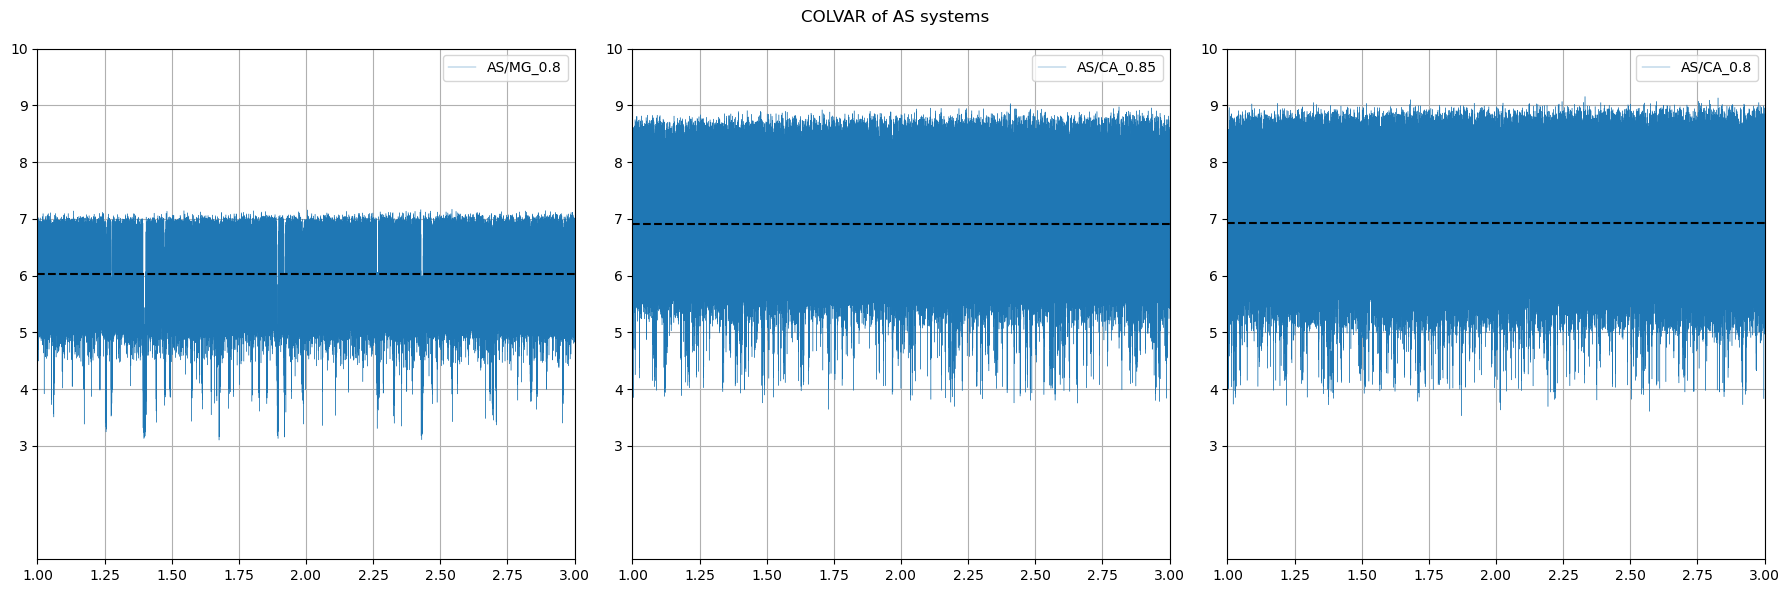

In [4]:
fig, ax = plt.subplots(1, Nsystems, figsize = (Nsystems*6, 6))

for i in range(Nsystems):
    ax[i].plot(COLVARS[i]['time']/1000**2, COLVARS[i]['cn'], label = FOLDERS[i], lw=0.3)
    ax[i].legend()
    ax[i].set_yticks([3, 4, 5, 6, 7, 8, 9, 10])
    ax[i].set_ylim(1, 10)
    ax[i].set_xlim(*Tminmax)
    ax[i].grid()
    ax[i].axhline(np.mean(COLVARS[i]['cn']), linestyle = '--', color = 'k')

plt.suptitle(f'COLVAR of AS systems')
plt.tight_layout()

# 2. Reweighting

In [5]:
'''
Do reweighting using COLVAR files 
'''

dG = pd.DataFrame(index = ['dG_PMF', 'dG_R', 'dG_I', 'dG0'], columns = FOLDERS)

dist, cn, fes, Nbins_DP, Nbins_CN, Bonds_DP, Bonds_CN = [None for _ in range(Nsystems)], [None for _ in range(Nsystems)], [None for _ in range(Nsystems)], [None for _ in range(Nsystems)], [None for _ in range(Nsystems)], [None for _ in range(Nsystems)], [None for _ in range(Nsystems)]
for i in range(Nsystems):    
    dist[i], cn[i], fes[i], Nbins_DP[i], Nbins_CN[i], Bonds_DP[i], Bonds_CN[i] = read_fes_2d(FOLDERS[i], NAME = '30')
    dG[FOLDERS[i]] = reweight_2d(COLVARS[i], 
                dist[i], cn[i], fes[i], Nbins_DP[i], Nbins_CN[i], Bonds_DP[i], Bonds_CN[i],
                FOLDERS[i], DATA_FOLDER=DATA_FOLDER, FSAVE=True
                )
display(dG.round(2))

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


178 137 [0.0315449, 3.15281] [2.74549, 7.52194]
176 174 [0.0687757, 3.14946] [3.28703, 9.38322]
175 181 [0.0668522, 3.14052] [3.17414, 9.50791]


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/veretenenko/miniconda3/envs/plumed/lib/libplumedKernel.so" +++


,AS/MG_0.8,AS/CA_0.85,AS/CA_0.8
dG_PMF,-5.17,-4.30,-1.45
dG_R,1.94,1.94,1.94
dG_I,-0.50,-0.60,-0.50
dG0,-3.73,-2.97,-0.02


## 2.1. 2D projection of FES on L-CN

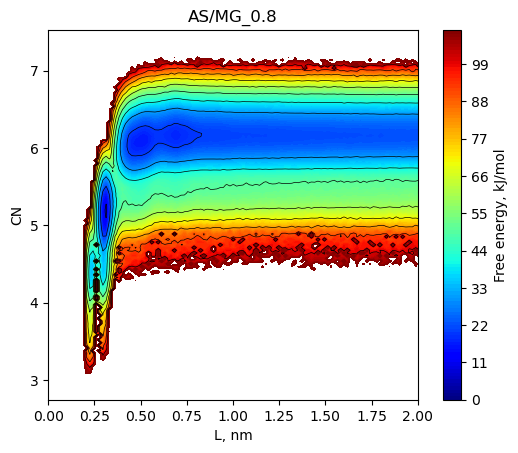

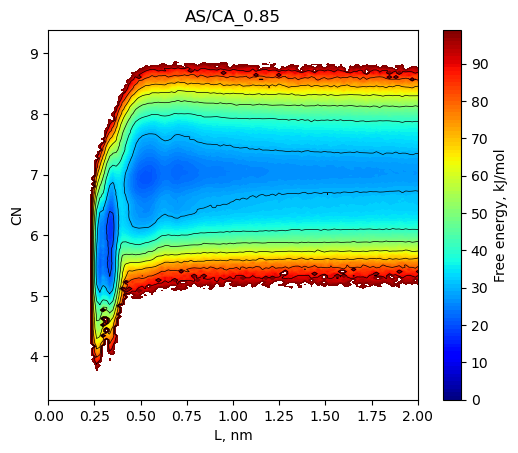

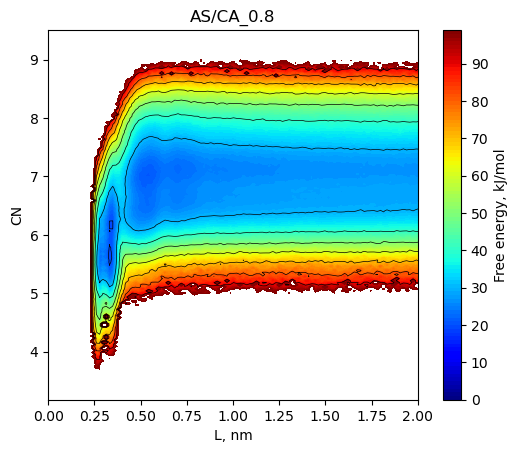

In [6]:
for i in range(Nsystems):
    plot_2D_ace(FOLDERS[i])

## 2.2. 1D projection of FES on L

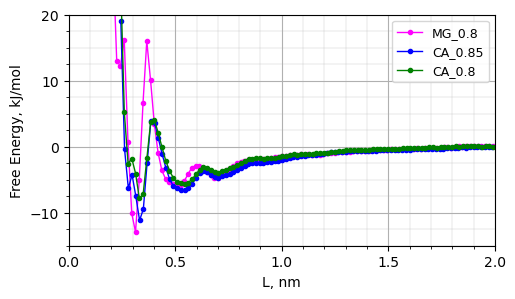

In [7]:
fig, ax = plt.subplots(figsize = (5.5, 3))

for i in range(Nsystems):
    plot_1D_ace(FOLDERS[i], 'Reweighting_data', fig, ax,
                color = colors[FOLDERS[i].split('/')[1]]) 

plt.legend(fontsize=9)
plt.savefig(f'IMAGES/AS_PMF.svg', dpi=300, bbox_inches = 'tight')

# 3. Block analysis

In [8]:
N_blocks, dG_mean, dG_std = {}, {}, {}
for i in range(Nsystems):
    N_blocks[i], dG_mean[i], dG_std[i] = calc_dG_stride_reweight(
        COLVARS[i], dist[i], cn[i], fes[i], 
        Nbins_DP[i], Nbins_CN[i], Bonds_DP[i], Bonds_CN[i], 
        FOLDERS[i])

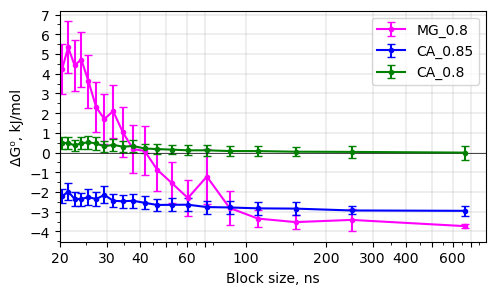

In [9]:
fig, ax = plt.subplots(figsize = (5.5, 3))

for i in range(Nsystems):
    SYS_NAME = FOLDERS[i].split('/')[1]

    plt.errorbar(len(COLVARS[i])/N_blocks[i]/1000, 
                dG_mean[i], dG_std[i], fmt='.-',
                color = colors[SYS_NAME],
                capsize=3, 
                label=SYS_NAME,
                )

plt.xlabel('Block size, ns')
plt.ylabel('ΔG⁰, kJ/mol')

ax.grid(True, which='major', linestyle='-', lw=0.3,)
plt.axhline(0, color = 'k', lw=0.5)
plt.legend()

plt.xscale('log')
plt.xlim(20, 800)  # Устанавливаем пределы оси X

xticks = ax.xaxis.get_minor_ticks()
for tick in xticks:
    tick.label1.set_visible(False)
ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=np.arange(0.1, 0.8, 0.1)))
ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10, subs=np.arange(0.1, 0.8, 0.05)))
formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4))
ax.xaxis.set_major_formatter(formatter)

ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(-12, 8, 1)))
ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(np.arange(-12, 8, 0.5)))

plt.savefig(f'IMAGES/AS_block_dG_mean.svg', bbox_inches ='tight', dpi=300)
plt.show()

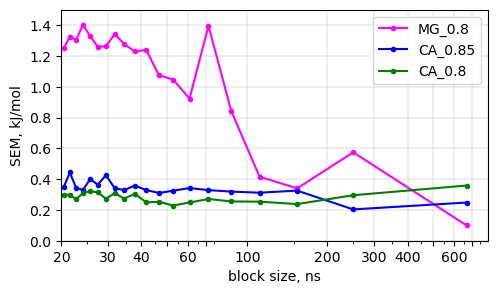

In [10]:
fig, ax = plt.subplots(figsize = (5.5, 3))

for i in range(Nsystems):
    SYS_NAME = FOLDERS[i].split('/')[1]

    plt.plot(len(COLVARS[i])/N_blocks[i]/1000, dG_std[i], '.-', 
            color = colors[SYS_NAME],
             label = SYS_NAME
             )

plt.ylabel('SEM, kJ/mol')
plt.xlabel('block size, ns')

ax.grid(True, which='major', linestyle='-', lw=0.3,)
plt.legend()

plt.xscale('log')
plt.xlim(20, 800)  # Устанавливаем пределы оси X

xticks = ax.xaxis.get_minor_ticks()
for tick in xticks:
    tick.label1.set_visible(False)
ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs=np.arange(0.1, 0.8, 0.1)))
ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10, subs=np.arange(0.1, 0.8, 0.05)))
formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4))
ax.xaxis.set_major_formatter(formatter)

plt.ylim(0, 1.5)

plt.savefig(f'IMAGES/AS_block_dG_std.svg', bbox_inches ='tight', dpi=300)

plt.show()

In [11]:
! jupyter nbconvert --to notebook AS-systems-postprocessing.ipynb --output NOTEBOOKS/AS-postprocessing
! jupyter nbconvert --to html AS-systems-postprocessing.ipynb --output NOTEBOOKS/AS-postprocessing

[NbConvertApp] Converting notebook AS-systems-postprocessing.ipynb to notebook
[NbConvertApp] Writing 588995 bytes to NOTEBOOKS/AS-postprocessing.ipynb
[NbConvertApp] Converting notebook AS-systems-postprocessing.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 886237 bytes to NOTEBOOKS/AS-postprocessing.html
